In [6]:
! pip install langchain_community langchain_core langchain_groq langgraph python-dotenv

In [15]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

In [21]:
from langgraph.graph import StateGraph, START, END, add_messages
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import os

load_dotenv()

memory = MemorySaver()

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=os.getenv("GROQ_API_KEY"))
llm_with_tools = llm.bind_tools(tools=tools)

class BasicState(TypedDict):
    messages: Annotated[List, add_messages]

def model(state: BasicState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state: BasicState):
    last_message = state["messages"][-1]
    if(hasattr(last_message, "tool_calls") and
    len(last_message.tool_calls) > 0):
        return "tools"
    else:
        return END


graph = StateGraph(BasicState)
graph.add_node(model, "model")
graph.add_node("tools", ToolNode(tools=tools))

graph.add_edge(START, "model") # explicitly add and connect the START node to the model node
# graph.set_entry_point("model") # you can also do this as Start is the default entry point

graph.add_conditional_edges(
    "model",
    tools_router,
    {
        "tools": "tools",
        "__end__": END
    }
)

graph.add_edge("tools", "model")

app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

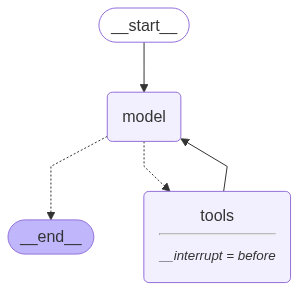

In [22]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
config = {"configurable": {
    "thread_id": 1
}}

events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in New York?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in New York?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ecgdxq0b4)
 Call ID: ecgdxq0b4
  Args:
    query: current weather in New York


In [25]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [26]:
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (ecgdxq0b4)
 Call ID: ecgdxq0b4
  Args:
    query: current weather in New York
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Weather in Manhattan in September 2025 (New York)", "url": "https://world-weather.info/forecast/usa/manhattan_3/september-2025/", "content": "Detailed ⚡ Manhattan Weather Forecast for September 2025 – day ... Monday, 1 September. Day. +75°. 7.4. 30.2. 42%. +66°. 06:23 am. 07:28 pm.", "score": 0.84215075}, {"title": "New York, NY Monthly Weather - AccuWeather", "url": "https://www.accuweather.com/en/us/new-york/10021/september-weather/349727", "content": "# New York, NY\n\nNew York\n\nNew York\n\n## Around the Globe\n\nAround the Globe\n\n### Hurricane Tracker\n\n### Severe Weather\n\n### Radar & Maps\n\n### News & Features\n\n### Astronomy\n\n### Business\n\n### C